In [1]:
from mplsoccer import Pitch, FontManager, VerticalPitch
URL_font = 'https://github.com/google/fonts/blob/main/ofl/fjallaone/FjallaOne-Regular.ttf?raw=true'
robotto_regular = FontManager(URL_font)
# Data Manipulation
import math
import pickle

# Model
from statsbombpy import sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df_tiros = pd.read_csv('archivos/tirosStatsBomb_modeloxG_v2.csv')

In [3]:
df_nuevo = pd.DataFrame(columns = ['end_x', 'goalMouthY', 'goalMouthZ', 'xG', 'outcome'])

In [4]:
df_tiros['len_end_loc'] = df_tiros['shot_end_location'].apply(len)
df_tiros = df_tiros[df_tiros['len_end_loc'] > 14]

In [5]:
for i in range(len(df_tiros)):
    new_row = df_tiros.shot_end_location.iloc[i].replace("[", "").replace("]", "").split(', ')
    new_row.append(df_tiros.shot_statsbomb_xg.iloc[i])
    new_row.append(df_tiros.shot_outcome.iloc[i])
    df_nuevo.loc[len(df_nuevo)] = new_row

In [6]:
df_nuevo[['end_x', 'goalMouthY', 'goalMouthZ']] = df_nuevo[['end_x', 'goalMouthY', 'goalMouthZ']].astype(float)

In [30]:
df_nuevo[df_nuevo['outcome'] == 'Post'].describe()

,end_x,goalMouthY,goalMouthZ,xG
count,472.000000,472.000000,472.000000,472.000000
mean,119.983686,39.943432,1.726271,0.146926
std,0.130688,3.487058,1.102607,0.167212
min,118.000000,35.500000,0.000000,0.004795
25%,120.000000,36.200000,0.575000,0.041871
50%,120.000000,39.650000,1.900000,0.086959
75%,120.000000,43.900000,2.800000,0.186220
max,120.000000,44.400000,3.000000,0.897061


In [8]:
tiros_al_arco = df_nuevo[(df_nuevo['goalMouthY'] >= 35.8) & (df_nuevo['goalMouthY'] <= 44.2) & (df_nuevo['goalMouthZ'] <= 2.6)]
tiros_al_arco.shape

(7798, 5)

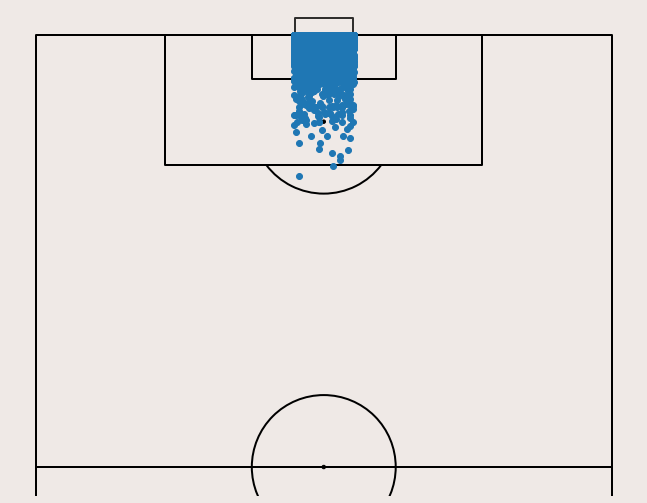

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
facecolor = "#EFE9E6"
fig.set_facecolor(facecolor)
pitch = VerticalPitch(pitch_type='statsbomb',goal_type='box', goal_alpha=.8, pitch_color=facecolor, line_color = 'black', half=True)
pitch.draw(ax=ax)

pitch.scatter(tiros_al_arco.end_x, tiros_al_arco.goalMouthY,ax=ax)

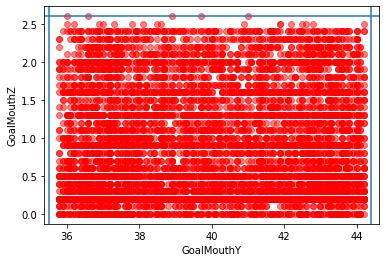

In [10]:
plt.scatter(tiros_al_arco['goalMouthY'], tiros_al_arco['goalMouthZ'], color='red', label='Goles', alpha=.5)
#plt.scatter(menos_prob['goalMouthY'], menos_prob['goalMouthZ'], color='blue', label='Goles', alpha=.25)

plt.xlabel('GoalMouthY')
plt.ylabel('GoalMouthZ')
plt.axhline(2.6)
plt.axvline(35.5)
plt.axvline(44.4)

In [11]:
tiros_al_arco['DistanceY'] = np.sqrt(np.square(40-tiros_al_arco['goalMouthY']))
tiros_al_arco['DistanceZ'] = np.sqrt(np.square(0-tiros_al_arco['goalMouthZ']))
tiros_al_arco['goal'] = np.where(tiros_al_arco['outcome'] == 'Goal', True, False)

In [12]:
tiros_al_arco

,end_x,goalMouthY,goalMouthZ,xG,outcome,DistanceY,DistanceZ,goal
0,114.8,40.6,1.6,0.353289,Saved,0.6,1.6,False
1,115.5,39.1,1.0,0.069527,Saved,0.9,1.0,False
3,120.0,36.1,0.6,0.030002,Post,3.9,0.6,False
4,118.1,39.1,1.0,0.516879,Saved,0.9,1.0,False
5,120.0,43.1,0.2,0.069699,Goal,3.1,0.2,True
...,...,...,...,...,...,...,...,...
16419,120.0,42.5,0.3,0.783500,Goal,2.5,0.3,True
16420,115.8,39.3,0.0,0.035833,Saved,0.7,0.0,False
16423,115.7,37.8,0.0,0.115056,Saved,2.2,0.0,False
16425,116.9,43.6,2.1,0.029767,Saved,3.6,2.1,False


In [13]:
X = tiros_al_arco.drop(columns=['goal', 'end_x', 'goalMouthY','goalMouthZ', 'outcome'])
y = tiros_al_arco['goal']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=27, stratify=y)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder()),
    ],
    remainder='passthrough'  # Mantener las variables numéricas sin modificar
)

model = Pipeline([
    ('classifier', LogisticRegression())
])

In [16]:
model.fit(X_train, y_train)

Pipeline(steps=[('classifier', LogisticRegression())])

In [17]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.742948717948718
Precision: 0.7048611111111112
Recall: 0.3911368015414258
F1 Score: 0.5030978934324659


In [18]:
probabilities = model.predict_proba(X)[:, 1]
probabilities = pd.DataFrame(probabilities, columns=['xGoT'])
X_with_prob = pd.concat([X.reset_index(drop=True), probabilities], axis=1)

In [19]:
tiros_al_arco_with_prob = pd.concat([tiros_al_arco.reset_index(drop=True), probabilities], axis=1)

In [20]:
X_with_prob['dif'] = X_with_prob['xGoT'] - X_with_prob['xG']
X_with_prob.dif.describe()

count    7798.000000
mean        0.162052
std         0.079849
min        -0.047533
25%         0.099172
50%         0.159992
75%         0.220767
max         0.409294
Name: dif, dtype: float64

In [21]:
tiros_al_arco_with_prob['dif'] = tiros_al_arco_with_prob['xGoT'] - tiros_al_arco_with_prob['xG']


In [22]:
mas_prob = tiros_al_arco_with_prob[tiros_al_arco_with_prob['dif'] > .35]
menos_prob = tiros_al_arco_with_prob[tiros_al_arco_with_prob['dif'] < 0]


In [23]:
tiros_al_arco_with_prob.dif.describe()

count    7798.000000
mean        0.162052
std         0.079849
min        -0.047533
25%         0.099172
50%         0.159992
75%         0.220767
max         0.409294
Name: dif, dtype: float64

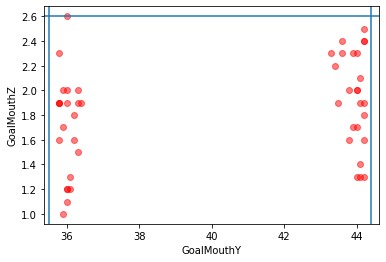

In [31]:
plt.scatter(mas_prob['goalMouthY'], mas_prob['goalMouthZ'], color='red', label='Goles', alpha=.5)
#plt.scatter(menos_prob['goalMouthY'], menos_prob['goalMouthZ'], color='blue', label='Goles', alpha=.25)

plt.xlabel('GoalMouthY')
plt.ylabel('GoalMouthZ')
plt.axhline(2.6)
plt.axvline(35.5)
plt.axvline(44.4)

In [39]:
tiros_al_arco_with_prob.goal.sum(), tiros_al_arco_with_prob.xGoT.sum()

(2592, 2602.975297311064)

In [40]:
import pickle

# Guardar el modelo en un archivo
with open('modelo_goles_esperados_alarco.pkl', 'wb') as archivo:
    pickle.dump(model, archivo)